# Introduction to Stan

In [ ]:
import stan
import nest_asyncio
nest_asyncio.apply()

import scipy.stats as sc
import numpy as np
import matplotlib.pyplot as plt

### Poisson - gamma model

Consider the conjugate model for Poisson data specified Exercise 4.2.

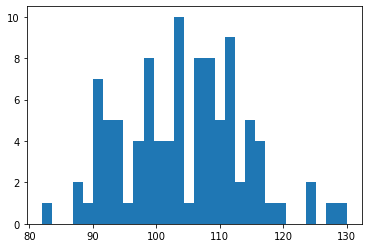

In [2]:
# set hyperparameters for the prior
a = 10.
b = 0.1

# sample parameter from the prior
theta = sc.gamma.rvs(a, scale=1/b)

# sample n observations conditional on theta
n = 100

x = sc.poisson.rvs(theta, size=n)

plt.hist(x, 30);

In [3]:
# define the model for Stan

poisson_gamma_model = """
    data {
        int<lower=0> N;
        array[N] int<lower=0> x;
        real<lower=0> a;
        real<lower=0> b;
    }
    parameters {
        real<lower=0> theta;                // Poisson mean
    }
    model {
        theta ~ gamma(a, b);
        
        for (n in 1:N) {
          x[n] ~ poisson(theta);            // iid Poisson(theta)
        }
    }
"""

In [4]:
# build the Stan object for the poisson gamma model

data = {'N': len(x),'x': x.tolist(), 'a': a, 'b': b}

posterior = stan.build(poisson_gamma_model, data=data, random_seed=1)

Building...



Building: found in cache, done.Messages from stanc:


In [5]:
# run the MCMC algorithm 

fit = posterior.sample(num_chains=1, num_samples=1000)

Sampling:   0%
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!


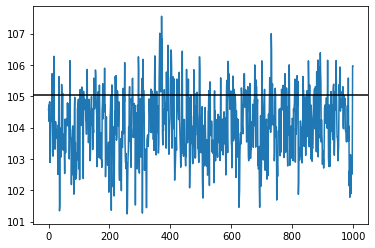

In [6]:
# trace plot of theta 

theta_sample = fit['theta'][0]

plt.plot(theta_sample)
plt.axhline(theta, color='k');

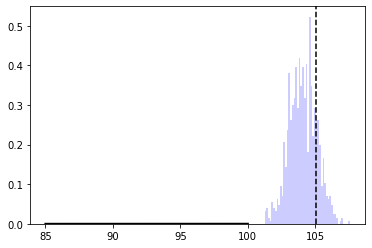

In [7]:
## support of the plot
x_grid = np.linspace(85, 100, 1000)

## plot histogram of sample obtained with Stan
# light blue
plt.hist(theta_sample, 50, density=True, color='b', alpha=0.2)

## plot of exact posterior density of theta
# black
plt.plot(x_grid, sc.gamma(a + sum(x), scale = 1 / (b + len(x))).pdf(x_grid), color="k",linestyle="-", lw=2)
plt.axvline(theta, color='k', linestyle='--');

### Student grade simulation

This section gives the code discussed in Section 6.1 of the lecture notes.

In [8]:
# sample data from a hypothetical class of n students obtaining grades from p tests.

def sample_student_grades(n=30,p=5,seed=0): #n students, p tests
    gen = np.random.default_rng(seed=seed)
    mu,sigma=sample_student_grade_parameters(gen)
    z=gen.normal(mu,sigma,size=n)
    X=[gen.binomial(100,1/(1.0+np.exp(-z_i)),size=p) for z_i in z]
    return(X,mu,sigma)

def sample_student_grade_parameters(gen,a=1,b=.5,m=0,tau=.5):
    sigma=1.0/np.sqrt(gen.gamma(a,1.0/b))
    mu=gen.normal(m,tau*sigma)
    return(mu,sigma)

n, p = 30, 5
X, mu, sigma = sample_student_grades(n, p)

In [9]:
## Specify the model for Stan

student_grade_model = """
    data {
            int<lower=0> n; // number of students
            int<lower=0> p; // number of tests
            array[n, p] int<lower=0, upper=100> X; // student test grades
            real<lower=0> tau;
            real<lower=0> a;
            real<lower=0> b;
        }
        parameters {
            array[n] real z;
            real mu;
            real<lower=0> sigma_sq;
        }
        transformed parameters {
            array[n] real<lower=0, upper=1> theta;
            real sigma;
            theta = inv_logit(z);
            sigma = sqrt(sigma_sq);
        }
        model {
            sigma_sq ~ inv_gamma(a,b);
            mu ~ normal(0, sigma * tau);
            z ~ normal(mu, sigma);
            for (i in 1:n)
              X[i] ~ binomial(100,theta[i]);
        }
"""

In [10]:
sm_data = {'n':n, 'p':p, 'tau':0.5, 'a':1, 'b':0.5, 'X':X}

# build the Stan object for the model 
sm = stan.build(student_grade_model,sm_data,random_seed=1)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_zsgpstqo/model_5jycl5ft.stan', line 26, column 30: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).


In [ ]:
# Select the number of MCMC chains and iterations, then sample
chains, samples, burn = 4, 10000, 1000
fit=sm.sample(num_chains=chains, num_samples=samples, num_warmup=burn, save_warmup=False)

Sampling:   0%

In [ ]:
## trace plots of the parameter of interest
## and approximate posterior density of mu

def plot_samples(fit,par,name,true_val=None):
    fig,axs=plt.subplots(2,2,figsize=(10,4),constrained_layout=True)
    fig.canvas.manager.set_window_title('Posterior for '+par)
    for i,j in [(i,j) for i in range(2) for j in range(2)]:
        axs[i,j].autoscale(enable=True, axis='x', tight=True)
    axs[0,0].set_title('Trace plot of log posterior density')
    axs[0,1].set_title('Trace plot of posterior samples of '+name)
    axs[1,0].set_title('Convergence of chain averages for '+name)
    axs[1,1].set_title('Approximate posterior density of '+name)
    par_mx=fit[par].reshape(samples,chains)
    lp_mx=fit['lp__'].reshape(samples,chains)
    for i in range(chains):
        x=i*samples+np.arange(samples)
        axs[0,0].plot(x,lp_mx[:,i])
        axs[0,1].plot(x,par_mx[:,i])
        axs[1,0].plot(x,np.cumsum(par_mx[:,i])/range(1,samples+1))
    axs[1,1].hist(par_mx.flatten(),200, density=True);
    if true_val is not None:
        axs[1,1].axvline(true_val, color='c', lw=2, linestyle='--')
    plt.show()

plot_samples(fit,'mu',r'$\mu$',true_val=mu)

In [ ]:
print("this has worked")